<a href="https://colab.research.google.com/github/erichbarreto/Atividade10_RESTIC36/blob/main/Atividade_10_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação dos dados e bibliotecas


In [1]:
# @title
#Importação das bibliotecas
import os
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow
import cv2
import csv


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense # Importação dos dados e bibliotecas

 # This line is likely a comment and needs to be fixed.  It's not valid python.

from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc,f1_score
import matplotlib.pyplot as plt



#Download das imagens
!pip install kaggle
!kaggle datasets download -d arbazkhan971/cuhk-face-sketch-database-cufs --force
!unzip -oq "cuhk-face-sketch-database-cufs.zip"


# Caminho da pasta com as imagens
pasta_imagens = "photos"

Dataset URL: https://www.kaggle.com/datasets/arbazkhan971/cuhk-face-sketch-database-cufs
License(s): copyright-authors
 88% 99.0M/113M [00:00<00:00, 276MB/s]
100% 113M/113M [00:00<00:00, 260MB/s] 


# Criação dos rótulos

In [2]:



# Nome do arquivo CSV onde os rótulos serão salvos
arquivo_rotulos = "rotulos.csv"

def criarCsvRotulo():
  # Criação ou abertura do arquivo CSV
  with open(arquivo_rotulos, mode='w', newline='') as arquivo_csv:
    escritor = csv.writer(arquivo_csv)
    escritor.writerow(["nome_imagem", "rotulo"])  # Cabeçalho do arquivo CSV

    # Percorre os arquivos na pasta
    for nome_imagem in sorted(os.listdir(pasta_imagens)):
      caminho_imagem = os.path.join(pasta_imagens, nome_imagem)

      # Verifica se é um arquivo de imagem
      if os.path.isfile(caminho_imagem) and nome_imagem.lower().endswith(('.jpg')):
        # Carrega e exibe a imagem
        img = cv2.imread(caminho_imagem, cv2.IMREAD_UNCHANGED)
        cv2_imshow(img)

        # Solicita o rótulo do usuário
        print(f"Rotule a imagem '{nome_imagem}': 0 - Masculino, 1 - Feminino\n")
        while True:
          try:
            rotulo = int(input("Digite o rótulo (0 ou 1): "))
            if rotulo in [0, 1]:
              break
            else:
              print("Entrada inválida. Digite 0 ou 1.")
          except ValueError:
            print("Entrada inválida. Digite um número inteiro (0 ou 1).")

        # Adiciona o rótulo ao arquivo CSV
        escritor.writerow([nome_imagem, rotulo])


  print(f"Rotulação concluída. Os rótulos foram salvos em '{arquivo_rotulos}'.")

# Pergunta ao usuário se deseja fazer a rotulagem ou utilizar o pré definido
decisao = input("Deseja utilizar o arquivo pré rotulados das imagens ou rotular? (S para sim ou N para não)")
if decisao.upper() == "N":
  os.remove(arquivo_rotulos)
  criarCsvRotulo()

else:
  try:
    # Download via git
    !wget "https://raw.githubusercontent.com/erichbarreto/Atividade10_RESTIC36/refs/heads/main/rotulos.csv" -O rotulos.csv

    print("Arquivo baixado com sucesso.")
  except Exception as e:
    print(f"Erro ao baixar o arquivo: {e}")



Deseja utilizar o arquivo pré rotulados das imagens ou rotular? (S para sim ou N para não)s
--2024-12-03 21:39:00--  https://raw.githubusercontent.com/erichbarreto/Atividade10_RESTIC36/refs/heads/main/rotulos.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2895 (2.8K) [text/plain]
Saving to: ‘rotulos.csv’

rotulos.csv         100%[===================>]   2.83K  --.-KB/s    in 0s      

2024-12-03 21:39:00 (29.9 MB/s) - ‘rotulos.csv’ saved [2895/2895]

Arquivo baixado com sucesso.


# Divisão dos dados

In [3]:

# Configurações
img_height, img_width = 250, 200  # Dimensões das imagens

# 1. Carregar o CSV com pandas
# Tentar carregar o arquivo baixado
df = pd.read_csv(arquivo_rotulos)

# 2. Criar listas de caminhos de imagens e rótulos
imagens = []
rotulos = []

for _, row in df.iterrows():
    caminho_imagem = os.path.join(pasta_imagens, row['nome_imagem'])
    if os.path.exists(caminho_imagem):
        # Carregar e redimensionar a imagem
        img = load_img(caminho_imagem, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0  # Normalizar os pixels (0-1)
        imagens.append(img_array)
        rotulos.append(row['rotulo'])

# Converter para arrays numpy
imagens = np.array(imagens)
rotulos = np.array(rotulos)

# 3. Converter os rótulos para categorias (one-hot encoding)
rotulos_categoricos = to_categorical(rotulos, num_classes=2)


# Dividir em treino, validação e teste
#treinamento
X_temp, X_teste, y_temp, y_teste = train_test_split(
    imagens, rotulos_categoricos, test_size=0.2, random_state=23
)
#validação
X_treino, X_validacao, y_treino, y_validacao = train_test_split(
    X_temp, y_temp, test_size=0.375, random_state=23  # 0.375 equivale a 30% do total
)

print(f"Treino: {X_treino.shape}, Validação: {X_validacao.shape}, Teste: {X_teste.shape}")

# Agora os dados estão prontos para treinar a rede neural


Treino: (93, 250, 200, 3), Validação: (57, 250, 200, 3), Teste: (38, 250, 200, 3)


# Treinamento

In [8]:
# @title

#Definição da rede
# Entrada com 32 filtros 3x3, função de ativação: relu
# Redução maxPooling 2x2
# redução para vetor unidimensional
# Camada densa com 128 neurônios

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')  # 2 saídas: masculino e feminino
])

# Compilação do modelo
otimizador = Adam(learning_rate=0.0001) # ajuste no aprendizado do modelo
model.compile(optimizer=otimizador, loss='binary_crossentropy', metrics=['accuracy'])

# Treinamento
history = model.fit(X_treino, y_treino, epochs=10, validation_data=(X_validacao, y_validacao), batch_size=32)

# Avaliação
print("Avaliação nos dados de validação:")
model.evaluate(X_validacao, y_validacao)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.4607 - loss: 1.6424 - val_accuracy: 0.5965 - val_loss: 5.1149
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.7753 - loss: 2.7529 - val_accuracy: 0.5965 - val_loss: 2.3806
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7479 - loss: 1.3978 - val_accuracy: 0.8596 - val_loss: 0.5744
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.8730 - loss: 0.6643 - val_accuracy: 0.5965 - val_loss: 0.9415
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.7753 - loss: 0.6060 - val_accuracy: 0.5965 - val_loss: 1.5585
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.8026 - loss: 0.6691 - val_accuracy: 0.7193 - val_loss: 0.6403
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8520 - loss: 0.3912 - val_accuracy: 0.8596 - val_loss: 0.4400
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9296 - loss: 0.3924 - val_accuracy: 0.7193 - val_loss: 0.6990
Epoch 9/10
3/

[0.5303032398223877, 0.8070175647735596]

# Avaliação

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        28
           1       1.00      0.70      0.82        10

    accuracy                           0.92        38
   macro avg       0.95      0.85      0.89        38
weighted avg       0.93      0.92      0.92        38

F1-Score: 0.8235294117647058


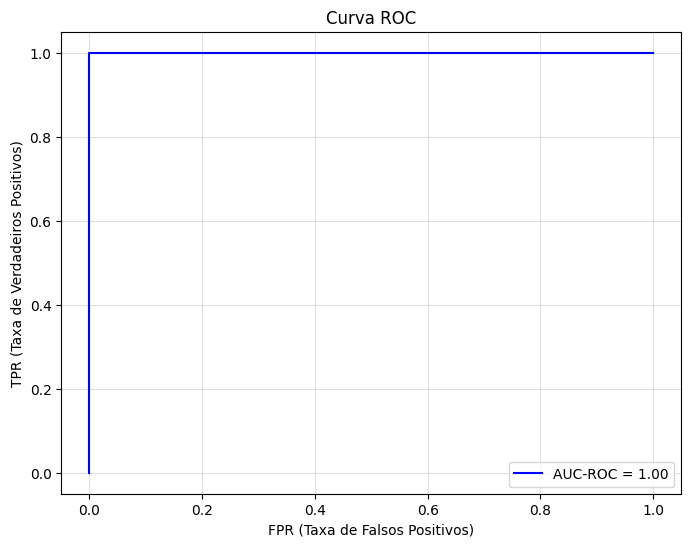

In [9]:
# @title


# Avaliação no conjunto de teste
y_pred = model.predict(X_teste)
y_pred_class = np.argmax(y_pred, axis=1)  # Predição das classes

# Verdadeiros rótulos das imagens de teste
y_true = np.argmax(y_teste, axis=1)

# Imprimir o relatório de classificação (F1-Score, precisão, recall, etc.)
print(classification_report(y_true, y_pred_class))

# Cálculo da F1-Score
f1 = f1_score(y_true, y_pred_class)
print(f"F1-Score: {f1}")

# Obter apenas as probabilidades da classe positiva
y_pred_positive = y_pred[:, 1]

# Calcular taxa de FPR, TPR e thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_pred_positive)

# Calcular a AUC-ROC
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {roc_auc:.2f}')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha de referência
plt.title('Curva ROC')
plt.xlabel('FPR (Taxa de Falsos Positivos)')
plt.ylabel('TPR (Taxa de Verdadeiros Positivos)')
plt.legend(loc='lower right')
plt.grid(alpha=0.4)
plt.show()



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


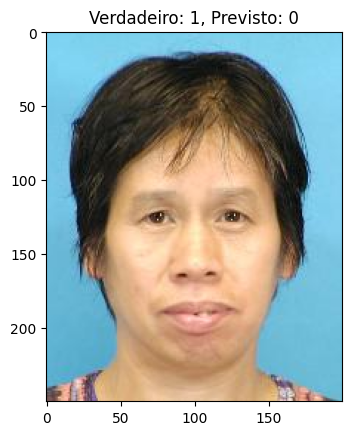

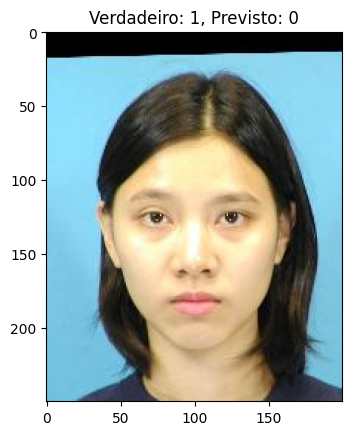

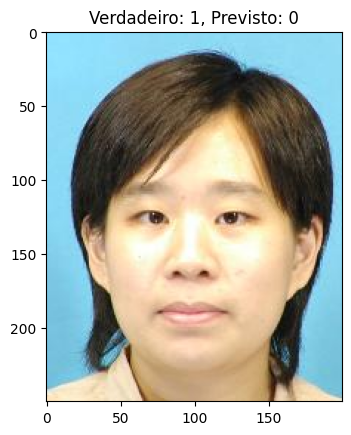

In [10]:


# Obter previsões do modelo
predictions = model.predict(X_teste)

# Converter previsões para rótulos binários
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_teste, axis=1)

# Identificar índices de classificações incorretas
incorrect_indices = np.where(predicted_labels != true_labels)[0]

# Exibir imagens mal classificadas com rótulos
for i in incorrect_indices:
  plt.imshow(X_teste[i])
  plt.title(f"Verdadeiro: {true_labels[i]}, Previsto: {predicted_labels[i]}")
  plt.show()
